# Litteraturbanken Author 
version 1.21 -  added link hub  

* this [notebook](https://github.com/salgo60/open-data-examples/blob/master/Litteraturbanken%20Author.ipynb)
  * [video Swedish](https://youtu.be/ttcboFaBi5U)
 
* [Wikidata:WikiProject_Sweden/The_Swedish_Literature_bank](https://www.wikidata.org/wiki/Wikidata:WikiProject_Sweden/The_Swedish_Literature_bank)

* [video exempel hur en post skapas](https://youtu.be/Grmp8_DZq8o)

#### Other sources we sync
* check for [pictures in SPA for WD objecst connected to Litteraturbanken](https://github.com/salgo60/spa2Commons/blob/main/Notebook/Litteraturbanken%20SPA.ipynb)
  * **Status** _same as_ [WD - LIBRIS XL - Litterturbanken](https://github.com/salgo60/spa2Commons/blob/main/Notebook/Litteraturbanken%20-%20samma%20som.ipynb)
  * [Notebook Matcha Litteraturbanken med bilder SPA](https://github.com/salgo60/spa2Commons/blob/main/Notebook/Litteraturbanken%20SPA.ipynb)

* [Arken](https://github.com/salgo60/open-data-examples/blob/master/Arken.ipynb) 
  * WD [Property:P8899](https://www.wikidata.org/wiki/Property:P8899) 
* [Kulturpersoner Uppsalakyrkogård](https://github.com/salgo60/open-data-examples/blob/master/Check%20WD%20kulturpersoner%20uppsalakyrkogardar.ipynb)
* [Litteraturbanken](https://github.com/salgo60/open-data-examples/blob/master/Litteraturbanken%20Author.ipynb) 
  * WD property [P5101](https://www.wikidata.org/wiki/Property_talk:P5101) [P5123](https://www.wikidata.org/wiki/Property_talk:P5123)
  *  [Litteraturkartan](https://litteraturbanken.se/litteraturkartan)
     * WD property [P9213](https://www.wikidata.org/wiki/Property:P9213)
* [Nobelprize.org](https://github.com/salgo60/open-data-examples/blob/master/Nobel%20API.ipynb)
  * WD [property 8024](https://www.wikidata.org/wiki/Property:P8024)
* [SBL](https://github.com/salgo60/open-data-examples/blob/master/SBL.ipynb) 
  * WD [property 3217](https://www.wikidata.org/wiki/Property:P3217) 
* [SKBL](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb)
  * WD [property 4963](https://www.wikidata.org/wiki/Property:P4963)
* [Svenska Akademien](https://github.com/salgo60/open-data-examples/blob/master/Svenska%20Akademien.ipynb) 
  * WD [property 5325](https://www.wikidata.org/wiki/Property:P5325) 

#### Misc
* [T238932 API Litteraturbanken]([https://phabricator.wikimedia.org/T238932)
  * good API documention has not been found
  * GITHUB [spraakbanken/littb-frontend](https://github.com/spraakbanken/littb-frontend)
      * Question 
        * ~~how to see [JSON for a record 23](https://github.com/spraakbanken/littb-frontend/issues/23)~~
        * ~~[feedback data 24](https://github.com/spraakbanken/littb-frontend/issues/24)~~  
          * question if they will have [Persistent Litteraturbanken place id](https://github.com/spraakbanken/littb-frontend/issues/24#issuecomment-711140342)
  * API [get_authors](https://litteraturbanken.se/api/get_authors)
  * [url_list](https://litteraturbanken.se/api/url_list)
  * [API List all 0-10 include](https://litteraturbanken.se/api/list_all/etext,faksimil,pdf?from=0&to=10&include=authors,forfattare,lbworkid,titlepath,title,librisid,mediatype,main_author.author_id)
    * [List all 0-10](https://litteraturbanken.se/api/list_all/etext,faksimil,pdf?from=0&to=10)
  * Wikidata 
    * property [P5101](https://www.wikidata.org/wiki/Property:P5101)
    * [other properties](https://w.wiki/eck) on the same object as Litterturbanken Author
* [Wikidata properties also available](https://w.wiki/eck) when we have P5101

**The objective** 
1. Find all Litteraturbanken Author objects that has Show True
1. Try to match Wikidata or create a new object for as many authors in Litteraturbanken as possible
  1. lesson learned not all authors are identified by Litteraturbanken --> maybe we should not create everyone in Wikidata or is Wikidata a good place to find relations e.g. [Louise Müller](https://www.wikidata.org/wiki/Q100566908?uselang=sv) same as
     1. Alvin [alvin-person:6474](http://www.alvin-portal.org/alvin/view.jsf?pid=alvin-person:6474)
     1. wife Riksarkivet SBL _J Daniel A Müller_ [id=8596](https://sok.riksarkivet.se/sbl/Presentation.aspx?id=8596) 
     1. VIAF [18128821](https://viaf.org/viaf/18128821/)
        1. LIBRISXL [qn259h685g929bf](https://libris.kb.se/katalogisering/qn259h685g929bf) / [JSON](https://libris.kb.se/qn259h685g929bf/data.jsonld)
1. If Litteraturbanken has identified an author with LIBRIS id and we dont find it in Wikidata we create it

**Lesson learned**
1. we need to filter using Show True
  1-1. looks like we need better filter e.g. "[CanthM](https://litteraturbanken.se/f%C3%B6rfattare/CanthM)" has false but has text see [tweet question](https://twitter.com/salgo60/status/1313834219794296834?s=20)
2. in Wikidata we get entries from my earlier load but also Mix-and-Match [katalog 1223](https://mix-n-match.toolforge.org/#/catalog/1223) --> we have also got the form "authorid_norm" that I feel we should not use --> some cleaning



## Issues
### 1) Filter out authors with no books 
* BergenstråhleJ miss books 
* BjorklundJA miss books

**solution** Filter on field Show

LitteraturbankenTotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==True]   

### 2) copyright on metadata?
Should be ok see [JSON for a record 23 comment 707542448](https://github.com/spraakbanken/littb-frontend/issues/23#issuecomment-707542448)

### 3) Persistent indentifiers for Litteraturbanken
Example what Litteraturbanken plans to do see [Facebook](https://www.facebook.com/Litteraturbanken.se/videos/261954861599359)
* suggestion that they use Public identifiers see [question https24#issuecomment-711140342](https://github.com/spraakbanken/littb-frontend/issues/24#issuecomment-711140342)

In [1]:
import ipyplot
listOfImageNames = ['LitteraturbankenWD.png']

ipyplot.plot_images(listOfImageNames,img_width=700)

In [2]:
from datetime import datetime
start_time  = datetime.now()
print("Last run: ", start_time)

Last run:  2025-03-05 11:16:50.149356


In [3]:
import urllib3, json
import pandas as pd 
http = urllib3.PoolManager() 
pd.set_option("display.max.columns", None) 
 
url = "https://litteraturbanken.se/api/get_authors"
r = http.request('GET', url)
data = json.loads(r.data)
df = pd.DataFrame(data["data"])

In [4]:
#df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5668 entries, 0 to 5667
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   authorid              5668 non-null   object 
 1   authorid_norm         5668 non-null   object 
 2   birth                 5668 non-null   object 
 3   db_checksum           5668 non-null   object 
 4   db_timestamp          5668 non-null   int64  
 5   db_timestamp_updated  3816 non-null   float64
 6   death                 4919 non-null   object 
 7   doc_type              5668 non-null   object 
 8   full_name             5668 non-null   object 
 9   gender                5668 non-null   object 
 10  imported              5063 non-null   object 
 11  intro                 832 non-null    object 
 12  name_for_index        5668 non-null   object 
 13  pictureinfo           875 non-null    object 
 14  searchable            5668 non-null   bool   
 15  show                 

In [5]:
#df.info() 
df[df['authorid_norm'].str.contains("BirchPfeifferC")]

,authorid,authorid_norm,birth,db_checksum,db_timestamp,db_timestamp_updated,death,doc_type,full_name,gender,imported,intro,name_for_index,pictureinfo,searchable,show,surname,updated,wikidata,librisid,intro_text,picture,popularity,dramawebben,pseudonym,sources,other_name,intro_author,intro_author_norm,bibliography,external_ref,presentation,seemore,changes
576,BirchPfeifferC,BirchPfeifferC,"{'date': '1800', 'plain': '1868'}",a4ba99138da2a29c78a5f39c12fe7649,1741079830449,NaN,{'plain': '1800'},author,Charlotte Birch-Pfeiffer,female,2018-10-25,None,"Birch-Pfeiffer, Charlotte",None,False,False,Birch-Pfeiffer,2019-05-14,"{'birthplace': [9.18, 48.7775], 'birthplace_la...",NaN,NaN,NaN,NaN,"{'intro': None, 'intro_author': 'LagercrantzMV...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# create a smaller dataset from this
listLittWD = []
for index,row in df.iterrows():
    new_item = dict()
    new_item['authorid'] = row['authorid']
    new_item['authorid_norm'] = row['authorid_norm']
    new_item['show'] = row['show']
    new_item['updated'] = row['updated']
    new_item['full_name'] = row['full_name']
    new_item['imported'] = row['imported']
    new_item['librisid'] = row['librisid']   
    wd = row['wikidata']
    try:            
        new_item['wd_hos_Litteraturbanken'] = wd['wikidata_id']
    except:
        pass
    listLittWD.append(new_item)
LitteraturbankenTot = pd.DataFrame(listLittWD,
                  columns=['full_name','authorid','wd_hos_Litteraturbanken','authorid_norm','show','updated','imported','librisid'])
#LitteraturbankenTot["updated"] = LitteraturbankenTot["updated"].astype("datetime64")
#LitteraturbankenTot["imported"] = LitteraturbankenTot["imported"].astype("datetime64")

LitteraturbankenTot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5668 entries, 0 to 5667
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   full_name                5668 non-null   object
 1   authorid                 5668 non-null   object
 2   wd_hos_Litteraturbanken  4138 non-null   object
 3   authorid_norm            5668 non-null   object
 4   show                     5668 non-null   bool  
 5   updated                  5063 non-null   object
 6   imported                 5063 non-null   object
 7   librisid                 3342 non-null   object
dtypes: bool(1), object(7)
memory usage: 315.6+ KB


In [7]:
#LitteraturbankenTot["authorid"].value_counts()

In [8]:
# flag I guess we should use
LitteraturbankenTot["show"].value_counts()

show
True     4639
False    1029
Name: count, dtype: int64

In [9]:
LitteraturbankenTotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==True] 

LitteraturbankenTotShow.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4639 entries, 0 to 5667
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   full_name                4639 non-null   object
 1   authorid                 4639 non-null   object
 2   wd_hos_Litteraturbanken  3958 non-null   object
 3   authorid_norm            4639 non-null   object
 4   show                     4639 non-null   bool  
 5   updated                  4240 non-null   object
 6   imported                 4240 non-null   object
 7   librisid                 2815 non-null   object
dtypes: bool(1), object(7)
memory usage: 294.5+ KB


In [10]:
#LitteraturbankenTotShow

### Latest updated at Litteraturbanken

In [11]:
# latest updated 
LitteraturbankenTotShow = LitteraturbankenTotShow.sort_values(by=['updated'], ascending=[False])
LitteraturbankenTotShow = LitteraturbankenTotShow.reset_index(drop=True)  

LitteraturbankenTotShow[:70]

,full_name,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid
0,Anna Sahlin,SahlinAnna,Q132874081,SahlinAnna,True,2025-04-07,2023-10-30,tr57b11c3ncbklg
1,Frans G. Bengtsson,BengtssonFG,Q444002,BengtssonFG,True,2025-03-04,2025-02-03,NaN
2,Jean Baptist von Schweitzer,SchweitzerJB,Q69022,SchweitzerJB,True,2025-03-03,2025-03-03,NaN
3,Conrad Fristedt,FristedtC,NaN,FristedtC,True,2025-03-03,2025-03-03,NaN
4,Reinhold Hemström,HemströmR,Q132897509,HemstromR,True,2025-03-03,2025-03-03,1zcgkxmk4tz8jgc
...,...,...,...,...,...,...,...,...
65,Eva Jaquette Lidner,LidnerEJ,NaN,LidnerEJ,True,2025-03-03,2025-03-03,NaN
66,Gudmund Leonhard Silfverstolpe,SilfverstolpeGL,Q6176230,SilfverstolpeGL,True,2025-03-03,2021-04-06,hftx1js150xwx1v
67,Gustaf Fredrik Åkerhielm,ÅkerhielmGF,NaN,AkerhielmGF,True,2025-03-03,2025-03-03,mkz254x51rzbdqx
68,Carl August Grevesmöhlen,GrevesmöhlenCA,Q5867391,GrevesmohlenCA,True,2025-03-03,2025-03-03,20dgj8sl4vsx2dp


### Latest imported at Litteraturbanken

In [12]:
LitteraturbankenTotShow = LitteraturbankenTotShow.sort_values(by=['imported'], ascending=[False])
LitteraturbankenTotShow = LitteraturbankenTotShow.reset_index(drop=True)  

LitteraturbankenTotShow[:410]

,full_name,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid
0,Hans Sachs,SachsHans,Q19543,SachsHans,True,2025-03-03,2025-03-03,64jlmjhq431s0sh
1,Per August Carlsson,CarlssonPA,NaN,CarlssonPA,True,2025-03-03,2025-03-03,75kmp6fr4vvj132
2,Samuel Clason,ClasonSam,Q5609612,ClasonSam,True,2025-03-03,2025-03-03,khwz23x34hsdrcn
3,Emanuel Wahlgren,WahlgrenE,NaN,WahlgrenE,True,2025-03-03,2025-03-03,NaN
4,Ed. H. Castenskjold,CastenskjoldEH,Q132897318,CastenskjoldEH,True,2025-03-03,2025-03-03,pm13zbt749t4k62
...,...,...,...,...,...,...,...,...
405,Johan Olof Imnelius,ImneliusJO,NaN,ImneliusJO,True,2024-01-29,2024-01-29,NaN
406,Adrien Decourcelle,DecourcelleA,Q953704,DecourcelleA,True,2024-01-29,2024-01-29,31fjmkqm311zx76
407,Oscar Ahlgren,AhlgrenO,Q132446093,AhlgrenO,True,2024-01-29,2024-01-29,hftx2bl11xdxcfb
408,Cecilia af Klercker,KlerckerC,Q28922704,KlerckerC,True,2024-10-28,2024-01-08,20dgkg0l10khqdb


## Wikidata
query WIkidata for all records with an Littearturbanken Author id

In [13]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys,json
import pandas as pd 

from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

# https://w.wiki/ffr
query = """SELECT (REPLACE(STR(?item), ".*Q", "Q") AS ?WikidataID)  ?authorid WHERE {
?item wdt:P31 wd:Q5.
?item wdt:P5101 ?authorid
} order by ?authorid"""

def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']
    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

WDLittbanktot = get_sparql_dataframe(endpoint_url, query)


In [14]:
WDLittbanktot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4143 entries, 0 to 4142
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   WikidataID  4143 non-null   object
 1   authorid    4143 non-null   object
dtypes: object(2)
memory usage: 64.9+ KB


Duplicates in WD https://w.wiki/eM2
We try to have one if two then set one to preferred rang

In [15]:
WDLittbanktot[WDLittbanktot.duplicated(subset=['WikidataID'])].count()

WikidataID    17
authorid      17
dtype: int64

Check if we get LilljegrenJ from Wikidata as Wikidata has a big delay right now 2020-10-08 see 
[Grafana Lag](https://grafana.wikimedia.org/d/000000489/wikidata-query-service?orgId=1&refresh=1m)


In [16]:
WDLittbanktot[WDLittbanktot['authorid'].str.contains("WahlinKr")]

,WikidataID,authorid


## Merge Litteraturbanken dataset with Wikidata
Finds if we have a mismatch

In [17]:
#merge 
dfmerge = pd.merge(WDLittbanktot, LitteraturbankenTotShow,how='outer', on='authorid',indicator=True)
# left_only is propably that we have authorid_norm in WIkidata instead of preferred authorid
# right_only is missing in WD (could be they are part of left_only)
#dfmerge["_merge"].value_counts()   
dfmerge['_merge'] = dfmerge['_merge'].str.replace('left_only','WD_only').str.replace('right_only','Litterturbanken_only')
dfmerge.rename(columns={"_merge": "WD_Litteraturbanken"},inplace = True)    
dfmerge = dfmerge.sort_values(by=['updated'], ascending=[False])

dfmerge[0:30]  

,WikidataID,authorid,full_name,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,WD_Litteraturbanken
3183,Q132874081,SahlinAnna,Anna Sahlin,Q132874081,SahlinAnna,True,2025-04-07,2023-10-30,tr57b11c3ncbklg,both
299,Q444002,BengtssonFG,Frans G. Bengtsson,Q444002,BengtssonFG,True,2025-03-04,2025-02-03,NaN,both
4760,NaN,SaagK,Kristjan Saag,NaN,SaagK,True,2025-03-03,2006-08-21,NaN,Litterturbanken_only
188,Q48900,AriostoL,Ludovico Ariosto,Q48900,AriostoL,True,2025-03-03,2017-04-09,wt799wbf2hvx8h4,both
4167,NaN,JönssonHj,Hjalmar Jönsson,NaN,JonssonHj,True,2025-03-03,2025-03-03,c9pswbpw3sfz67f,Litterturbanken_only
4166,NaN,HögqvistJ,Jean Högqvist,NaN,HogqvistJ,True,2025-03-03,2025-03-03,NaN,Litterturbanken_only
4165,NaN,HagbergM,Marianne Hagberg,NaN,HagbergM,True,2025-03-03,2025-03-03,hftx5xp14jtbxt3,Litterturbanken_only
4164,NaN,RhodinPN,Peter Niklas Rhodin,NaN,RhodinPN,True,2025-03-03,2025-03-03,xv8bdscg44vr6xr,Litterturbanken_only
4163,NaN,LindbohmLR,Lars Robert Lindbohm,NaN,LindbohmLR,True,2025-03-03,2025-03-03,rp351xs90jr1rjk,Litterturbanken_only
4162,NaN,HollenderS,Sigurd Hollender,NaN,HollenderS,True,2025-03-03,2025-03-03,NaN,Litterturbanken_only


In [18]:
# WikidataID is Wikidata object
# wd_hos_Litteraturbanken is the Wikidata object at Litteraturbanken 
dfmerge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4843 entries, 3183 to 4842
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   WikidataID               4143 non-null   object
 1   authorid                 4843 non-null   object
 2   full_name                4639 non-null   object
 3   wd_hos_Litteraturbanken  3958 non-null   object
 4   authorid_norm            4639 non-null   object
 5   show                     4639 non-null   object
 6   updated                  4240 non-null   object
 7   imported                 4240 non-null   object
 8   librisid                 2815 non-null   object
 9   WD_Litteraturbanken      4843 non-null   object
dtypes: object(10)
memory usage: 416.2+ KB


In [19]:
dfmerge["show"].value_counts()

show
True    4639
Name: count, dtype: int64

### Check diff Wikidata <-> Litteraturbanken 

1. **WD_only** --> är oftast att Wikidata har den normerade egenskapen och skall bytas

2. **Litterturbanken_only** skall skapas/matchas i Wikidata särskild om LIBRIS id finns

  2-1. se [mix-and-match katalog 1223](https://mix-n-match.toolforge.org/#/catalog/1223) för verktyg att koppla ihop
 

In [20]:
# left_only is propably that we have authorid_norm in WIkidata instead of preferred authorid
# right_only is missing in WD (could be they are part of left_only)
dfmerge["WD_Litteraturbanken"].value_counts()  

WD_Litteraturbanken
both                    3939
Litterturbanken_only     700
WD_only                  204
Name: count, dtype: int64

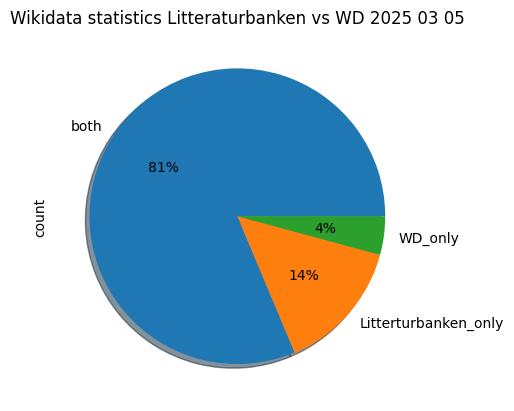

In [21]:
%matplotlib inline 
import matplotlib.pyplot as plt   
mergeCheckNumber = dfmerge["WD_Litteraturbanken"].value_counts()  
plotmerge = mergeCheckNumber.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0, \
                   title = "Wikidata statistics Litteraturbanken vs WD " + start_time.strftime('%Y %m %d'))
plt.savefig('LitteraturbankenWD.png')
plt.show()


In [22]:
mergeCheckNumber

WD_Litteraturbanken
both                    3939
Litterturbanken_only     700
WD_only                  204
Name: count, dtype: int64

### Check diff Wikidata <-> Litteraturbanken were we have LIBRISid

In [23]:
#mergewithLibris

In [24]:
mergewithLibris = dfmerge[dfmerge["librisid"].notnull()].copy() 
#plotmerge = mergewithLibris.plot.pie( \
#                   autopct='%1.0f%%', \
#                   shadow=True, startangle=0, \
#                   title = "Wikidata statistics Litteraturbanken with LIBRIS " + start_time.strftime('%Y %m %d'))
#plotmerge.plot( kind = 'bar',subplots=True) 
#plt.title("LIBRIS ")
#plt.savefig('LitteraturbankenWDLibris.png')
#plt.show()


In [25]:
mergewithLibris.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2815 entries, 3183 to 150
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   WikidataID               2776 non-null   object
 1   authorid                 2815 non-null   object
 2   full_name                2815 non-null   object
 3   wd_hos_Litteraturbanken  2776 non-null   object
 4   authorid_norm            2815 non-null   object
 5   show                     2815 non-null   object
 6   updated                  2815 non-null   object
 7   imported                 2815 non-null   object
 8   librisid                 2815 non-null   object
 9   WD_Litteraturbanken      2815 non-null   object
dtypes: object(10)
memory usage: 241.9+ KB


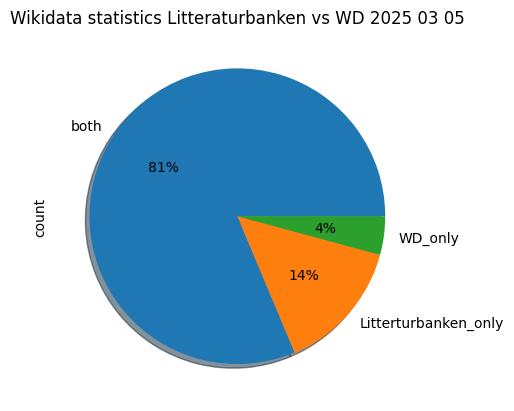

In [26]:


mergeCheckNumber = dfmerge["WD_Litteraturbanken"].value_counts()  
plotmerge = mergeCheckNumber.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0, \
                   title = "Wikidata statistics Litteraturbanken vs WD " + start_time.strftime('%Y %m %d'))
plt.savefig('LitteraturbankenWD.png')
plt.show()


In [27]:
mergeCheckNumber

WD_Litteraturbanken
both                    3939
Litterturbanken_only     700
WD_only                  204
Name: count, dtype: int64

In [28]:
pd.set_option("display.max.rows", None) 
 
wdonly = dfmerge[dfmerge["WD_Litteraturbanken"]=="WD_only"]
# could be items with Show false at Litteraturbanken 
wdonly.info()


<class 'pandas.core.frame.DataFrame'>
Index: 204 entries, 86 to 4110
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   WikidataID               204 non-null    object
 1   authorid                 204 non-null    object
 2   full_name                0 non-null      object
 3   wd_hos_Litteraturbanken  0 non-null      object
 4   authorid_norm            0 non-null      object
 5   show                     0 non-null      object
 6   updated                  0 non-null      object
 7   imported                 0 non-null      object
 8   librisid                 0 non-null      object
 9   WD_Litteraturbanken      204 non-null    object
dtypes: object(10)
memory usage: 17.5+ KB


In [29]:
wdonly.sample()

,WikidataID,authorid,full_name,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,WD_Litteraturbanken
2807,Q132444779,OllenB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD_only


In [30]:
LitteraturbankenTotShow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4639 entries, 0 to 4638
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   full_name                4639 non-null   object
 1   authorid                 4639 non-null   object
 2   wd_hos_Litteraturbanken  3958 non-null   object
 3   authorid_norm            4639 non-null   object
 4   show                     4639 non-null   bool  
 5   updated                  4240 non-null   object
 6   imported                 4240 non-null   object
 7   librisid                 2815 non-null   object
dtypes: bool(1), object(7)
memory usage: 258.4+ KB


In [31]:
wdonly_norm = pd.merge(wdonly, LitteraturbankenTotShow,how='outer', left_on='authorid', right_on='authorid_norm',indicator=True)
wdonly_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4823 entries, 0 to 4822
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   WikidataID                 204 non-null    object  
 1   authorid_x                 204 non-null    object  
 2   full_name_x                0 non-null      object  
 3   wd_hos_Litteraturbanken_x  0 non-null      object  
 4   authorid_norm_x            0 non-null      object  
 5   show_x                     0 non-null      object  
 6   updated_x                  0 non-null      object  
 7   imported_x                 0 non-null      object  
 8   librisid_x                 0 non-null      object  
 9   WD_Litteraturbanken        204 non-null    object  
 10  full_name_y                4639 non-null   object  
 11  authorid_y                 4639 non-null   object  
 12  wd_hos_Litteraturbanken_y  3958 non-null   object  
 13  authorid_norm_y            4639 n

In [32]:
#df[df['authorid_norm'].str.contains("WahlinK")] 
#df[df['authorid'].str.contains("SjödinS")] 
df[df['authorid'].str.contains("Homeros")] 



,authorid,authorid_norm,birth,db_checksum,db_timestamp,db_timestamp_updated,death,doc_type,full_name,gender,imported,intro,name_for_index,pictureinfo,searchable,show,surname,updated,wikidata,librisid,intro_text,picture,popularity,dramawebben,pseudonym,sources,other_name,intro_author,intro_author_norm,bibliography,external_ref,presentation,seemore,changes
2242,Homeros,Homeros,"{'date': '-750', 'plain': 'ca. 750 f. Kr.'}",b6726b91ea6c4c3131c16ec848ac6a27,1741079830368,1.741080e+12,{'plain': 'ca 650 f. Kr.'},author,Homeros,male,2014-02-11,None,Homeros,None,True,True,Homeros,2019-10-16,"{'birthplace': None, 'birthplace_label': None,...",0xbdfjvj5rjnrc0,NaN,NaN,176880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
#df[df['authorid'].str.contains("SimonsenM")] 

In [34]:
# has other_name = Malan Simonsen --> SimonsenM redirect to MarnersdóttirM
#df[df['authorid'].str.contains("MarnersdóttirM")] 
df[df['authorid'].str.contains("AdlersparreCA")] 


,authorid,authorid_norm,birth,db_checksum,db_timestamp,db_timestamp_updated,death,doc_type,full_name,gender,imported,intro,name_for_index,pictureinfo,searchable,show,surname,updated,wikidata,librisid,intro_text,picture,popularity,dramawebben,pseudonym,sources,other_name,intro_author,intro_author_norm,bibliography,external_ref,presentation,seemore,changes
18,AdlersparreCA,AdlersparreCA,"{'date': '1810', 'plain': '1810'}",0eded7b8efbcc014c0889007931dc9c7,1741079830573,1.741080e+12,"{'date': '1862', 'plain': '1862'}",author,Carl August Adlersparre,male,2021-03-01,\n<p>CARL AUGUST ADLERSPARRE (1810–1862): \n’g...,"Adlersparre, Carl August","Bild ur <a href=""/forfattare/Anonym/titlar/Nor...",True,True,Adlersparre,2023-11-27,"{'birthplace': [14.1166, 59.3106], 'birthplace...",sq4677hb49x6bfd,\nCARL AUGUST ADLERSPARRE (1810–1862): \n’gref...,True,6176.0,NaN,"[{'authorid': 'Albano_pseudonym', 'authorid_no...","[Bernhard Meijer, <a href=""/forfattare/MeijerB...",[Karl August Adlersparre],NaN,NaN,NaN,NaN,NaN,NaN,NaN


1. merge wdonly authorid on authorid_norm --> we get the authorid that we should use 
1. next step is create Quickstatement  for delete and upload the new one see example [Calc](https://docs.google.com/spreadsheets/d/1lw1wqTmFndxlltJHhyEyzQxoGTph6J2tdVCwgmJFHdI/edit?usp=sharing)


In [35]:
wdonlymerge = pd.merge(wdonly, LitteraturbankenTotShow, left_on='authorid', right_on='authorid_norm')
wdonlymerge[['WikidataID', 'authorid_x', 'authorid_y', 'show_y']]


,WikidataID,authorid_x,authorid_y,show_y
0,Q105742933,BjorklundJ,BjörklundJ,True
1,Q115983143,DagsdottirU,DagsdóttirU,True
2,Q115983145,DahlstromSO,DahlströmSO,True
3,Q115983149,EkelofCU,EkelöfCU,True
4,Q116975209,HinderakerA,HinderakerÅ,True
5,Q116290449,HojerT,HöjerT,True
6,Q116997583,HolmenG,HolménG,True
7,Q116998713,KallstromC,KällströmC,True
8,Q116999058,KonigCH,KönigCH,True
9,Q117009914,LindstromJE,LindströmJE,True


#### sss


In [36]:
wdonly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 204 entries, 86 to 4110
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   WikidataID               204 non-null    object
 1   authorid                 204 non-null    object
 2   full_name                0 non-null      object
 3   wd_hos_Litteraturbanken  0 non-null      object
 4   authorid_norm            0 non-null      object
 5   show                     0 non-null      object
 6   updated                  0 non-null      object
 7   imported                 0 non-null      object
 8   librisid                 0 non-null      object
 9   WD_Litteraturbanken      204 non-null    object
dtypes: object(10)
memory usage: 17.5+ KB


In [37]:
from IPython.display import HTML
wddelete = wdonly = dfmerge[dfmerge["WD_Litteraturbanken"]=="WD_only"].copy()  
wddelete["Littbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + wddelete["authorid"] + "'>link</a>"
wddelete["LittbankAPI"] = "<a href='https://litteraturbanken.se/api/get_author/" + wddelete["authorid"] + "'>API</a>"
wddelete["Wikidata"] = "<a href='https://www.wikidata.org/wiki/" + wddelete["WikidataID"] + "'>wd</a>"
pd.set_option("display.max.columns", None) 
HTML(wddelete[["show","Littbank","LittbankAPI","WikidataID","Wikidata","authorid"]].to_html(escape=False))

,show,Littbank,LittbankAPI,WikidataID,Wikidata,authorid
86,NaN,link,API,Q5547566,wd,AlmquistS
112,NaN,link,API,Q52714152,wd,AnckerS
114,NaN,link,API,Q4585247,wd,AnderbergB
141,NaN,link,API,Q4935813,wd,AnderssonI
153,NaN,link,API,Q451495,wd,AndreeE
184,NaN,link,API,Q5558934,wd,ArfvidssonN
207,NaN,link,API,Q132201420,wd,ArvidssonR
277,NaN,link,API,Q52634999,wd,BeckettSL
296,NaN,link,API,Q792799,wd,BenedekM
311,NaN,link,API,Q19298273,wd,BerfP


In [38]:
dfmerge_authorid_norm = pd.merge(wdonly, LitteraturbankenTotShow, left_on='authorid', right_on='authorid_norm',indicator=True)

In [39]:
dfmerge_authorid_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   WikidataID                 20 non-null     object  
 1   authorid_x                 20 non-null     object  
 2   full_name_x                0 non-null      object  
 3   wd_hos_Litteraturbanken_x  0 non-null      object  
 4   authorid_norm_x            0 non-null      object  
 5   show_x                     0 non-null      object  
 6   updated_x                  0 non-null      object  
 7   imported_x                 0 non-null      object  
 8   librisid_x                 0 non-null      object  
 9   WD_Litteraturbanken        20 non-null     object  
 10  Littbank                   20 non-null     object  
 11  LittbankAPI                20 non-null     object  
 12  Wikidata                   20 non-null     object  
 13  full_name_y                20 non-nul

In [40]:
dfmerge_authorid_norm.head()

,WikidataID,authorid_x,full_name_x,wd_hos_Litteraturbanken_x,authorid_norm_x,show_x,updated_x,imported_x,librisid_x,WD_Litteraturbanken,Littbank,LittbankAPI,Wikidata,full_name_y,authorid_y,wd_hos_Litteraturbanken_y,authorid_norm_y,show_y,updated_y,imported_y,librisid_y,_merge
0,Q105742933,BjorklundJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,<a href='https://litteraturbanken.se/api/get_a...,<a href='https://www.wikidata.org/wiki/Q105742...,J. Björklund,BjörklundJ,Q105742933,BjorklundJ,True,2017-04-12,2017-04-12,NaN,both
1,Q115983143,DagsdottirU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,<a href='https://litteraturbanken.se/api/get_a...,<a href='https://www.wikidata.org/wiki/Q115983...,Úlfhildur Dagsdóttir,DagsdóttirU,Q115983143,DagsdottirU,True,2014-03-17,2014-03-17,NaN,both
2,Q115983145,DahlstromSO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,<a href='https://litteraturbanken.se/api/get_a...,<a href='https://www.wikidata.org/wiki/Q115983...,Samuel Olof Dahlström,DahlströmSO,Q115983145,DahlstromSO,True,2017-05-10,2010-10-19,NaN,both
3,Q115983149,EkelofCU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,<a href='https://litteraturbanken.se/api/get_a...,<a href='https://www.wikidata.org/wiki/Q115983...,Carl Ulric Ekelöf,EkelöfCU,Q115983149,EkelofCU,True,2023-10-30,2015-10-12,NaN,both
4,Q116975209,HinderakerA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,<a href='https://litteraturbanken.se/api/get_a...,<a href='https://www.wikidata.org/wiki/Q116975...,Åse Hinderaker,HinderakerÅ,Q116975209,HinderakerA,True,NaN,NaN,NaN,both


In [41]:
#dfmerge_authorid_norm[{'WikidataID','authorid_x','authorid_y'}] 

### Check items not matched to Wikidata but has Librisid

In [42]:
dfmerge["WD_Litteraturbanken"].value_counts()  

WD_Litteraturbanken
both                    3939
Litterturbanken_only     700
WD_only                  204
Name: count, dtype: int64

In [43]:
Litterturbanken_only = dfmerge[dfmerge["WD_Litteraturbanken"]=="Litterturbanken_only"]  
Litterturbanken_only.info()
#Litterturbanken_only.head(50)

<class 'pandas.core.frame.DataFrame'>
Index: 700 entries, 4760 to 4842
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   WikidataID               0 non-null      object
 1   authorid                 700 non-null    object
 2   full_name                700 non-null    object
 3   wd_hos_Litteraturbanken  21 non-null     object
 4   authorid_norm            700 non-null    object
 5   show                     700 non-null    object
 6   updated                  618 non-null    object
 7   imported                 618 non-null    object
 8   librisid                 39 non-null     object
 9   WD_Litteraturbanken      700 non-null    object
dtypes: object(10)
memory usage: 60.2+ KB


In [44]:
wdonly


,WikidataID,authorid,full_name,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,WD_Litteraturbanken,Littbank,LittbankAPI,Wikidata
86,Q5547566,AlmquistS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,<a href='https://litteraturbanken.se/api/get_a...,<a href='https://www.wikidata.org/wiki/Q554756...
112,Q52714152,AnckerS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,<a href='https://litteraturbanken.se/api/get_a...,<a href='https://www.wikidata.org/wiki/Q527141...
114,Q4585247,AnderbergB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,<a href='https://litteraturbanken.se/api/get_a...,<a href='https://www.wikidata.org/wiki/Q458524...
141,Q4935813,AnderssonI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,<a href='https://litteraturbanken.se/api/get_a...,<a href='https://www.wikidata.org/wiki/Q493581...
153,Q451495,AndreeE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,<a href='https://litteraturbanken.se/api/get_a...,<a href='https://www.wikidata.org/wiki/Q451495...
184,Q5558934,ArfvidssonN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,<a href='https://litteraturbanken.se/api/get_a...,<a href='https://www.wikidata.org/wiki/Q555893...
207,Q132201420,ArvidssonR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,<a href='https://litteraturbanken.se/api/get_a...,<a href='https://www.wikidata.org/wiki/Q132201...
277,Q52634999,BeckettSL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,<a href='https://litteraturbanken.se/api/get_a...,<a href='https://www.wikidata.org/wiki/Q526349...
296,Q792799,BenedekM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,<a href='https://litteraturbanken.se/api/get_a...,<a href='https://www.wikidata.org/wiki/Q792799...
311,Q19298273,BerfP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,<a href='https://litteraturbanken.se/api/get_a...,<a href='https://www.wikidata.org/wiki/Q192982...


In [45]:
Litterturbanken_only.to_csv("LitteraturbankenAuthor_new.csv")
# LitteraturbankenAuthor_new.csv

In [46]:
Litterturbanken_only

,WikidataID,authorid,full_name,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,WD_Litteraturbanken
4760,NaN,SaagK,Kristjan Saag,NaN,SaagK,True,2025-03-03,2006-08-21,NaN,Litterturbanken_only
4167,NaN,JönssonHj,Hjalmar Jönsson,NaN,JonssonHj,True,2025-03-03,2025-03-03,c9pswbpw3sfz67f,Litterturbanken_only
4166,NaN,HögqvistJ,Jean Högqvist,NaN,HogqvistJ,True,2025-03-03,2025-03-03,NaN,Litterturbanken_only
4165,NaN,HagbergM,Marianne Hagberg,NaN,HagbergM,True,2025-03-03,2025-03-03,hftx5xp14jtbxt3,Litterturbanken_only
4164,NaN,RhodinPN,Peter Niklas Rhodin,NaN,RhodinPN,True,2025-03-03,2025-03-03,xv8bdscg44vr6xr,Litterturbanken_only
4163,NaN,LindbohmLR,Lars Robert Lindbohm,NaN,LindbohmLR,True,2025-03-03,2025-03-03,rp351xs90jr1rjk,Litterturbanken_only
4162,NaN,HollenderS,Sigurd Hollender,NaN,HollenderS,True,2025-03-03,2025-03-03,NaN,Litterturbanken_only
4161,NaN,AbrahamssonJ,J. Abrahamsson,NaN,AbrahamssonJ,True,2025-03-03,2025-03-03,NaN,Litterturbanken_only
4160,NaN,BerwaldMA,Mauritz August Berwald,NaN,BerwaldMA,True,2025-03-03,2025-03-03,NaN,Litterturbanken_only
4159,NaN,WallanderHj,Hjalmar Wallander,NaN,WallanderHj,True,2025-03-03,2025-03-03,31fhdbkm1l4ww0j,Litterturbanken_only


* See latest checked [LitteraturbankenAuthor_new.csv in GITHUB](https://github.com/salgo60/open-data-examples/blob/master/LitteraturbankenAuthor_new.csv)

In [47]:
#Get all items with no Wikidata item but has librisid --> can match them using Open Refine 
Litterturbanken_only[Litterturbanken_only['librisid'].notnull()].count()

WikidataID                  0
authorid                   39
full_name                  39
wd_hos_Litteraturbanken     2
authorid_norm              39
show                       39
updated                    39
imported                   39
librisid                   39
WD_Litteraturbanken        39
dtype: int64

## Errors funna nedan 
se felrapportering Litteraturbanken https://github.com/Litteraturbanken/littb-frontend/issues/60
* Dublett: 
* [SimonsenM](https://litteraturbanken.se/f%C3%B6rfattare/SimonsenM) är lite udda med en se [Malan Marnersdóttir](https://litteraturbanken.se/f%C3%B6rfattare/Marnersd%C3%B3ttirM/titlar) 
  * undran hur ser jag det i datat
  
Skapar en task på GITHUB         
* ~~[feedback data 24](https://github.com/spraakbanken/littb-frontend/issues/24)~~


In [48]:
Litterturbanken_only.info()

<class 'pandas.core.frame.DataFrame'>
Index: 700 entries, 4760 to 4842
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   WikidataID               0 non-null      object
 1   authorid                 700 non-null    object
 2   full_name                700 non-null    object
 3   wd_hos_Litteraturbanken  21 non-null     object
 4   authorid_norm            700 non-null    object
 5   show                     700 non-null    object
 6   updated                  618 non-null    object
 7   imported                 618 non-null    object
 8   librisid                 39 non-null     object
 9   WD_Litteraturbanken      700 non-null    object
dtypes: object(10)
memory usage: 60.2+ KB


In [49]:
Litterturbanken_onlyW = Litterturbanken_only[Litterturbanken_only['librisid'].notnull()][['full_name', 'WikidataID', 'authorid', 'WD_Litteraturbanken', 'librisid', 'show']].copy()
Litterturbanken_onlyW["Littbank"] = "<a target=_blank href='https://litteraturbanken.se/f%C3%B6rfattare/" + Litterturbanken_only["authorid"] + "'>link Litteraturbanken</a>"
Litterturbanken_onlyW["LittbankJSON"] = "<a target=_blank href='https://litteraturbanken.se/api/get_author/" + Litterturbanken_only["authorid"] + "'>json</a>"
Litterturbanken_onlyW["WDHub"] = "<a target=_blank href='https://hub.toolforge.org/P5587:" + Litterturbanken_only["librisid"] + "?site=wd'>Hub</a>"

Litterturbanken_onlyW.shape



(39, 9)

In [50]:
#Loop and find if its in WD using the hub tool 
import requests
def getLibrisWD (libris):
    # https://hub.toolforge.org/P5587:xxxx?format=json
    baseurl = "https://hub.toolforge.org/P5587:"
    huburl = baseurl + str(libris) + "?format=json"
    responseHub = requests.get(huburl)
    hubJson = json.loads(responseHub.text)
    wd = ""
    if "origin" in hubJson:
        wd = hubJson["origin"]["qid"]
    
    return wd
    
for index,row in Litterturbanken_onlyW.iterrows():
    #print(row)
    try:            
        wdobj = getLibrisWD(row["librisid"])
        if wdobj:
            print("\t\t",row["librisid"],row["authorid"],wdobj)

    except:
        print("Except")
        pass


		 1zcfhsdk289zw81 BornemanGHvon Q5582776
		 31fhjbgm10dfss9 LucretiusCarusT Q47154
		 75kmn8dr3hgv75k LagerbringS Q456732
		 gdsvzxn032qd1hm ValbäckFJ Q11859946
		 0xbdfjvj5rjnrc0 Homeros Q6691


In [51]:
Litterturbanken_onlyW.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39 entries, 4167 to 4755
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   full_name            39 non-null     object
 1   WikidataID           0 non-null      object
 2   authorid             39 non-null     object
 3   WD_Litteraturbanken  39 non-null     object
 4   librisid             39 non-null     object
 5   show                 39 non-null     object
 6   Littbank             39 non-null     object
 7   LittbankJSON         39 non-null     object
 8   WDHub                39 non-null     object
dtypes: object(9)
memory usage: 3.0+ KB


In [52]:
#Loop and find if its not WD and print them
    
for index,row in Litterturbanken_onlyW.iterrows():
    #print(row)
    try:            
        wdobj = getLibrisWD(row["librisid"])
        if wdobj:
            pass
            #print("\t\t",row["librisid"],row["authorid"],wdobj)
        else:
            print("\t\t",row["show"],row["librisid"],row["authorid"],wdobj)
 
    except:
        print("Except")
        pass


		 True c9pswbpw3sfz67f JönssonHj 
		 True hftx5xp14jtbxt3 HagbergM 
		 True xv8bdscg44vr6xr RhodinPN 
		 True rp351xs90jr1rjk LindbohmLR 
		 True 31fhdbkm1l4ww0j WallanderHj 
		 True pm1479g724sqbxr ÅströmG 
		 True ljx031444w2xd3f SöderströmEH 
		 True 20dgkghl5h6g2pw SöderlingC 
		 True 42gjlcrn3xm8dw3 HellmanCO 
		 True 53hkml5p0qtbfrm GasslanderK 
		 True nl02xl665p4ppvs JoelssonN 
		 True 5lcds4nn3bxfzgpz CallmanderR 
		 True rp357p392d4t4b6 EdquistE 
		 True sq4697qb3kmc2m8 TheorinB 
		 True nl025h062ck17jj MörnerOS 
		 True 64jlmk9q3b2nx4l KrokN 
		 True rp36bht90mzh056 SvedérJF 
		 True sq4695nb2hblvlk SvedinG 
		 True gdsvz1b049ndcnm SvedbergCE 
		 True khwz2c031561kdx MalmgrenG 
		 True 1zcgksxk3xcwf5p PeterssonCH 
		 True 42gjd3dn2k9w95p KaselliJ 
		 True b8nqlkdv2531621 MacfieA 
		 True khw030s35sskrz4 WinqvistPO 
		 True 75kmp6fr4vvj132 CarlssonPA 
		 True dbqt0qjx2xjwnvj ModigJ 
		 True sq47gngb38gms11 WeidarA 
		 True n4ttvc6xlr2l5kbh DagermanL 
		 True dbqswrtx1smltwd 

In [53]:
HTML(Litterturbanken_onlyW.to_html(escape=False))


,full_name,WikidataID,authorid,WD_Litteraturbanken,librisid,show,Littbank,LittbankJSON,WDHub
4167,Hjalmar Jönsson,NaN,JönssonHj,Litterturbanken_only,c9pswbpw3sfz67f,True,link Litteraturbanken,json,Hub
4165,Marianne Hagberg,NaN,HagbergM,Litterturbanken_only,hftx5xp14jtbxt3,True,link Litteraturbanken,json,Hub
4164,Peter Niklas Rhodin,NaN,RhodinPN,Litterturbanken_only,xv8bdscg44vr6xr,True,link Litteraturbanken,json,Hub
4163,Lars Robert Lindbohm,NaN,LindbohmLR,Litterturbanken_only,rp351xs90jr1rjk,True,link Litteraturbanken,json,Hub
4159,Hjalmar Wallander,NaN,WallanderHj,Litterturbanken_only,31fhdbkm1l4ww0j,True,link Litteraturbanken,json,Hub
4146,Gustav Adolf Åström,NaN,ÅströmG,Litterturbanken_only,pm1479g724sqbxr,True,link Litteraturbanken,json,Hub
4156,Erik Hjalmar Söderström,NaN,SöderströmEH,Litterturbanken_only,ljx031444w2xd3f,True,link Litteraturbanken,json,Hub
4155,Carl Söderling,NaN,SöderlingC,Litterturbanken_only,20dgkghl5h6g2pw,True,link Litteraturbanken,json,Hub
4153,Carl Otto Hellman,NaN,HellmanCO,Litterturbanken_only,42gjlcrn3xm8dw3,True,link Litteraturbanken,json,Hub
4152,Karl Gasslander,NaN,GasslanderK,Litterturbanken_only,53hkml5p0qtbfrm,True,link Litteraturbanken,json,Hub


In [54]:
Litterturbanken_onlyW.to_csv("LitteraturbankenAuthorWD_new.csv")

Använda csv fil med Open Refine
* video TBD

In [55]:
HTML(Litterturbanken_onlyW[['full_name','librisid','Littbank','authorid','LittbankJSON','WDHub']].to_html(escape=False))


,full_name,librisid,Littbank,authorid,LittbankJSON,WDHub
4167,Hjalmar Jönsson,c9pswbpw3sfz67f,link Litteraturbanken,JönssonHj,json,Hub
4165,Marianne Hagberg,hftx5xp14jtbxt3,link Litteraturbanken,HagbergM,json,Hub
4164,Peter Niklas Rhodin,xv8bdscg44vr6xr,link Litteraturbanken,RhodinPN,json,Hub
4163,Lars Robert Lindbohm,rp351xs90jr1rjk,link Litteraturbanken,LindbohmLR,json,Hub
4159,Hjalmar Wallander,31fhdbkm1l4ww0j,link Litteraturbanken,WallanderHj,json,Hub
4146,Gustav Adolf Åström,pm1479g724sqbxr,link Litteraturbanken,ÅströmG,json,Hub
4156,Erik Hjalmar Söderström,ljx031444w2xd3f,link Litteraturbanken,SöderströmEH,json,Hub
4155,Carl Söderling,20dgkghl5h6g2pw,link Litteraturbanken,SöderlingC,json,Hub
4153,Carl Otto Hellman,42gjlcrn3xm8dw3,link Litteraturbanken,HellmanCO,json,Hub
4152,Karl Gasslander,53hkml5p0qtbfrm,link Litteraturbanken,GasslanderK,json,Hub


In [56]:
#df[df['authorid_norm'].str.contains("ArfvidssonN")] 

In [57]:
#df[df['authorid_norm'].str.contains("ArfwidssonN")] 

### Find objects with Show false at Litteraturbanken 
If found in Wikidata they are candidates to be deleted in Wikidata 

* Looks like we have some oddities in the Litteraturbanken data as items with Show False looks ok to use see [tweet](https://twitter.com/salgo60/status/1313834219794296834?s=20)

In [58]:
LitteraturbankenTotNotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==False]  
dfmergeDelete = pd.merge(WDLittbanktot, LitteraturbankenTotNotShow,how='outer', on='authorid',indicator=True)

In [59]:
# both are candidates to be deleted as they have show False
dfmergeDelete["_merge"].value_counts()  

_merge
left_only     3973
right_only     859
both           170
Name: count, dtype: int64

In [60]:
dfmergeDeleteBoth = dfmergeDelete[dfmergeDelete["_merge"]=="both"].copy() 
del dfmergeDeleteBoth['_merge']
dfmergeDeleteBoth["Littbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + dfmergeDeleteBoth["authorid"] + "'>link Litteraturbanken</a>"
dfmergeDeleteBoth["LittbankJSON"] = "<a href='https://litteraturbanken.se/api/get_author/" + dfmergeDeleteBoth["authorid"] + "'>json</a>"
dfmergeDeleteBoth["Wikidata"] = "<a href='https://www.wikidata.org/wiki/" + dfmergeDeleteBoth["WikidataID"] + "'>WD</a>"
HTML(dfmergeDeleteBoth.to_html(escape=False))
# list ok but has Show False

,WikidataID,authorid,full_name,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,Littbank,LittbankJSON,Wikidata
86,Q5547566,AlmquistS,Sigfrid Almquist,Q5547566,AlmquistS,False,2024-10-28,2014-02-11,tr57bgqc00sszjd,link Litteraturbanken,json,WD
112,Q52714152,AnckerS,Stina Ancker,Q52714152,AnckerS,False,2014-03-07,2014-02-11,NaN,link Litteraturbanken,json,WD
114,Q4585247,AnderbergB,Bengt Anderberg,Q4585247,AnderbergB,False,2019-10-16,2010-09-20,qn244rz85nr8054,link Litteraturbanken,json,WD
141,Q4935813,AnderssonI,Ingrid Andersson,Q4935813,AnderssonI,False,2019-10-16,2014-02-11,vs689zpd2hs6914,link Litteraturbanken,json,WD
153,Q451495,AndreeE,Elfrida Andrée,Q451495,AndreeE,False,2019-10-16,2014-02-11,64jlmc0q24qqs81,link Litteraturbanken,json,WD
207,Q132201420,ArvidssonR,Rolf Arvidsson,Q132201420,ArvidssonR,False,2014-03-07,2014-02-11,NaN,link Litteraturbanken,json,WD
277,Q52634999,BeckettSL,Sandra L. Beckett,Q52634999,BeckettSL,False,2019-10-16,2014-02-11,vs69jw2d20tbhgc,link Litteraturbanken,json,WD
296,Q792799,BenedekM,Marcell Benedek,Q792799,BenedekM,False,2019-10-16,2014-02-11,75kmq0xr3kbf577,link Litteraturbanken,json,WD
311,Q19298273,BerfP,Paul Berf,Q19298273,BerfP,False,2019-10-16,2014-02-11,tr58hfgc4c6qbfb,link Litteraturbanken,json,WD
320,Q27523556,BergO,Olaf Berg,Q27523556,BergO,False,2014-03-07,2014-02-11,NaN,link Litteraturbanken,json,WD


In [61]:
dfmergeDeleteBoth.info()

<class 'pandas.core.frame.DataFrame'>
Index: 170 entries, 86 to 4110
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   WikidataID               170 non-null    object
 1   authorid                 170 non-null    object
 2   full_name                170 non-null    object
 3   wd_hos_Litteraturbanken  170 non-null    object
 4   authorid_norm            170 non-null    object
 5   show                     170 non-null    object
 6   updated                  150 non-null    object
 7   imported                 150 non-null    object
 8   librisid                 104 non-null    object
 9   Littbank                 170 non-null    object
 10  LittbankJSON             170 non-null    object
 11  Wikidata                 170 non-null    object
dtypes: object(12)
memory usage: 17.3+ KB


In [62]:
#List I think shouldnt have Show False in LItteraturbanken

ErrorShowFalseLitteraturbank = pd.DataFrame(['BirchPfeifferC','BjörkmanE','RomanusAlfvénAC','SjödinS',
                                    'TirénG','ÅströmP','DobbinL','HallbergP','JonssonErnst',
                                    'NordlingS','BerggrenH','AustenJ',
                                             'BjörnbergE'
                                             
                                            ],columns =['authorid'])
# Get list without errors
dfmergeDeleteCorrected = pd.merge(dfmergeDeleteBoth, ErrorShowFalseLitteraturbank,how='outer', on='authorid',indicator=True)
#HTML(dfmergeDeleteCorrected.to_html(escape=False))


## Problem records that has show false

In [63]:
ErrorShowFalseLitteraturbank["Litteraturbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + ErrorShowFalseLitteraturbank["authorid"] + "'>link</a>"
ErrorShowFalseLitteraturbank["get_author"] = "<a href='https://litteraturbanken.se/api/get_author/" + ErrorShowFalseLitteraturbank["authorid"] + "'>get_author</a>"

ErrorShowFalseLitteraturbank.sort_values(by=['authorid'],inplace=True, ascending=[True])
HTML(ErrorShowFalseLitteraturbank.to_html(escape=False))


,authorid,Litteraturbank,get_author
11,AustenJ,link,get_author
10,BerggrenH,link,get_author
0,BirchPfeifferC,link,get_author
1,BjörkmanE,link,get_author
12,BjörnbergE,link,get_author
6,DobbinL,link,get_author
7,HallbergP,link,get_author
8,JonssonErnst,link,get_author
9,NordlingS,link,get_author
2,RomanusAlfvénAC,link,get_author


## List to check
Indicates 
1. if we have objects with Show False in WIkidata or
1. Litteraturbanken has objects with books but has Show False

see also ErrorShowFalseLitteraturbank

**Lesson learned** we have bots that update from Litteraturbanken that sometimes add a mess....

In [64]:
# Should be empty else delete in Wikidata or add to ErrorShowFalseLitteraturbank
HTML(dfmergeDeleteCorrected[dfmergeDeleteCorrected["_merge"]=="left_only"].to_html(escape=False))

,WikidataID,authorid,full_name,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,Littbank,LittbankJSON,Wikidata,_merge
0,Q5547566,AlmquistS,Sigfrid Almquist,Q5547566,AlmquistS,False,2024-10-28,2014-02-11,tr57bgqc00sszjd,link Litteraturbanken,json,WD,left_only
1,Q52714152,AnckerS,Stina Ancker,Q52714152,AnckerS,False,2014-03-07,2014-02-11,NaN,link Litteraturbanken,json,WD,left_only
2,Q4585247,AnderbergB,Bengt Anderberg,Q4585247,AnderbergB,False,2019-10-16,2010-09-20,qn244rz85nr8054,link Litteraturbanken,json,WD,left_only
3,Q4935813,AnderssonI,Ingrid Andersson,Q4935813,AnderssonI,False,2019-10-16,2014-02-11,vs689zpd2hs6914,link Litteraturbanken,json,WD,left_only
4,Q451495,AndreeE,Elfrida Andrée,Q451495,AndreeE,False,2019-10-16,2014-02-11,64jlmc0q24qqs81,link Litteraturbanken,json,WD,left_only
5,Q132201420,ArvidssonR,Rolf Arvidsson,Q132201420,ArvidssonR,False,2014-03-07,2014-02-11,NaN,link Litteraturbanken,json,WD,left_only
6,Q52634999,BeckettSL,Sandra L. Beckett,Q52634999,BeckettSL,False,2019-10-16,2014-02-11,vs69jw2d20tbhgc,link Litteraturbanken,json,WD,left_only
7,Q792799,BenedekM,Marcell Benedek,Q792799,BenedekM,False,2019-10-16,2014-02-11,75kmq0xr3kbf577,link Litteraturbanken,json,WD,left_only
8,Q19298273,BerfP,Paul Berf,Q19298273,BerfP,False,2019-10-16,2014-02-11,tr58hfgc4c6qbfb,link Litteraturbanken,json,WD,left_only
9,Q27523556,BergO,Olaf Berg,Q27523556,BergO,False,2014-03-07,2014-02-11,NaN,link Litteraturbanken,json,WD,left_only


In [65]:
# Indicates that this member shouldnt be dfmergeDeleteCorrected
HTML(dfmergeDeleteCorrected[dfmergeDeleteCorrected["_merge"]=="right_only"].to_html(escape=False))

,WikidataID,authorid,full_name,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,Littbank,LittbankJSON,Wikidata,_merge
170,NaN,SjödinS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
171,NaN,TirénG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
172,NaN,ÅströmP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
173,NaN,HallbergP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
174,NaN,NordlingS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
175,NaN,BerggrenH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
176,NaN,AustenJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only


In [66]:
end = datetime.now()
print("Ended: ", end) 
print('Time elapsed (hh:mm:ass.ms) {}'.format(datetime.now() - start_time))

Ended:  2025-03-05 11:17:42.187645
Time elapsed (hh:mm:ass.ms) 0:00:52.038344
